In [2]:
!mamba install geopandas
!mamba install pandas
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.interpolate import RBFInterpolator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
import warnings
warnings.filterwarnings('ignore')

mambajs 0.19.13

Specs: xeus-python, numpy, matplotlib, pillow, ipywidgets>=8.1.6, ipyleaflet, scipy, geopandas, pandas
Channels: emscripten-forge, conda-forge

Solving environment...
Solving took 1.3668999999761582 seconds
All requested packages already installed.
mambajs 0.19.13

Specs: xeus-python, numpy, matplotlib, pillow, ipywidgets>=8.1.6, ipyleaflet, scipy, geopandas, pandas
Channels: emscripten-forge, conda-forge

Solving environment...
Solving took 1.1173000000119209 seconds
All requested packages already installed.


In [3]:
# 1. СОЗДАНИЕ СИНТЕТИЧЕСКИХ ДАННЫХ

print("="*80)
print("ЗАДАНИЕ 9: ИНТЕРПОЛЯЦИЯ (IDW vs RBF vs Gaussian Process)")
print("="*80)

np.random.seed(42)
n_points = 150  # количество точек измерений

# Создаём координаты в пределах области 0-100 км
x = np.random.uniform(0, 100, n_points)
y = np.random.uniform(0, 100, n_points)

# Создаём пространственную структуру данных
# Используем комбинацию тренда и локальных вариаций
trend = 20 + 0.1 * x + 0.05 * y  # линейный тренд

# Добавляем пространственную автокорреляцию (гауссово поле)
# Создаём сетку для построения коррелированного шума
grid_size = 20
x_grid = np.linspace(0, 100, grid_size)
y_grid = np.linspace(0, 100, grid_size)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

# Создаём коррелированное поле
corr_field = np.zeros((grid_size, grid_size))
center_x, center_y = 50, 50
for i in range(grid_size):
    for j in range(grid_size):
        dist = np.sqrt((x_grid[i] - center_x)**2 + (y_grid[j] - center_y)**2)
        corr_field[j, i] = 30 * np.exp(-dist/30) + 10 * np.sin(x_grid[i]/20) * np.cos(y_grid[j]/20)

# Интерполируем коррелированное поле в точки измерений
from scipy.interpolate import griddata
points_grid = np.array([(x, y) for x in x_grid for y in y_grid])
values_grid = corr_field.flatten()
spatial_corr = griddata(points_grid, values_grid, (x, y), method='cubic')

# Добавляем случайный шум
noise = np.random.normal(0, 2, n_points)

# Итоговые значения
z = trend + spatial_corr + noise

# Создаём DataFrame
df = pd.DataFrame({
    'x': x,
    'y': y,
    'z': z
})

print(f"\n ДАННЫЕ:")
print(f"   Количество точек: {len(df)}")
print(f"   Диапазон x: {df['x'].min():.1f} - {df['x'].max():.1f}")
print(f"   Диапазон y: {df['y'].min():.1f} - {df['y'].max():.1f}")
print(f"   Диапазон z: {df['z'].min():.2f} - {df['z'].max():.2f}")
print(f"   Среднее z: {df['z'].mean():.2f}")
print(f"   Стандартное отклонение z: {df['z'].std():.2f}")

ЗАДАНИЕ 9: ИНТЕРПОЛЯЦИЯ (IDW vs RBF vs Gaussian Process)

 ДАННЫЕ:
   Количество точек: 150
   Диапазон x: 0.6 - 98.7
   Диапазон y: 0.5 - 99.0
   Диапазон z: 17.15 - 52.14
   Среднее z: 36.32
   Стандартное отклонение z: 7.26


In [4]:
# 2. РАЗДЕЛЕНИЕ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ

print("\n" + "="*80)
print("РАЗДЕЛЕНИЕ ДАННЫХ")
print("="*80)

# Разделяем на train/test
X = df[['x', 'y']].values
y = df['z'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"   Обучающая выборка: {len(X_train)} точек")
print(f"   Тестовая выборка: {len(X_test)} точек")


РАЗДЕЛЕНИЕ ДАННЫХ
   Обучающая выборка: 120 точек
   Тестовая выборка: 30 точек


In [5]:
# 3. МЕТОД 1: IDW (Inverse Distance Weighting)

print("\n" + "="*80)
print("МЕТОД 1: IDW (Inverse Distance Weighting)")
print("="*80)

def idw_interpolation(X_train, y_train, X_test, power=2):
    """
    Интерполяция методом обратных взвешенных расстояний (IDW)
    
    Параметры:
    - X_train: координаты обучающих точек
    - y_train: значения в обучающих точках
    - X_test: координаты тестовых точек
    - power: степень веса (обычно 2)
    """
    y_pred = []
    
    for test_point in X_test:
        # Расстояния до всех обучающих точек
        distances = np.sqrt(np.sum((X_train - test_point)**2, axis=1))
        
        # Избегаем деления на ноль
        distances = np.maximum(distances, 1e-10)
        
        # Веса обратно пропорциональны расстоянию в степени power
        weights = 1.0 / (distances ** power)
        
        # Взвешенное среднее
        z_pred = np.sum(weights * y_train) / np.sum(weights)
        y_pred.append(z_pred)
    
    return np.array(y_pred)

# Пробуем разные степени для IDW
powers = [1, 2, 3]
best_power = 2
best_rmse_idw = np.inf

print("\n   Поиск оптимальной степени IDW:")

for power in powers:
    y_pred_idw = idw_interpolation(X_train, y_train, X_test, power=power)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_idw))
    mae = mean_absolute_error(y_test, y_pred_idw)
    
    print(f"   power={power}: RMSE={rmse:.3f}, MAE={mae:.3f}")
    
    if rmse < best_rmse_idw:
        best_rmse_idw = rmse
        best_power = power

# Используем лучшую степень
y_pred_idw = idw_interpolation(X_train, y_train, X_test, power=best_power)

mae_idw = mean_absolute_error(y_test, y_pred_idw)
rmse_idw = np.sqrt(mean_squared_error(y_test, y_pred_idw))
r2_idw = 1 - np.sum((y_test - y_pred_idw)**2) / np.sum((y_test - y_test.mean())**2)

print(f"\n РЕЗУЛЬТАТЫ IDW (power={best_power}):")
print(f"   MAE:  {mae_idw:.3f}")
print(f"   RMSE: {rmse_idw:.3f}")
print(f"   R²:   {r2_idw:.3f}")



МЕТОД 1: IDW (Inverse Distance Weighting)

   Поиск оптимальной степени IDW:
   power=1: RMSE=4.331, MAE=3.581
   power=2: RMSE=3.147, MAE=2.540
   power=3: RMSE=2.608, MAE=2.062

 РЕЗУЛЬТАТЫ IDW (power=3):
   MAE:  2.062
   RMSE: 2.608
   R²:   0.760


In [6]:
# 4. МЕТОД 2: RBF (Radial Basis Function)

print("\n" + "="*80)
print("МЕТОД 2: RBF (Radial Basis Function)")
print("="*80)

# Пробуем разные ядра RBF
kernels = ['multiquadric', 'inverse_multiquadric', 'gaussian', 'linear']
best_kernel = 'multiquadric'
best_rmse_rbf = np.inf

print("\n   Поиск оптимального ядра RBF:")

for kernel in kernels:
    try:
        rbf = RBFInterpolator(X_train, y_train.reshape(-1, 1), kernel=kernel)
        y_pred_rbf = rbf(X_test).flatten()
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_rbf))
        mae = mean_absolute_error(y_test, y_pred_rbf)
        
        print(f"   kernel={kernel}: RMSE={rmse:.3f}, MAE={mae:.3f}")
        
        if rmse < best_rmse_rbf:
            best_rmse_rbf = rmse
            best_kernel = kernel
    except:
        print(f"   kernel={kernel}: ошибка вычисления")

# Используем лучшее ядро
rbf = RBFInterpolator(X_train, y_train.reshape(-1, 1), kernel=best_kernel)
y_pred_rbf = rbf(X_test).flatten()

mae_rbf = mean_absolute_error(y_test, y_pred_rbf)
rmse_rbf = np.sqrt(mean_squared_error(y_test, y_pred_rbf))
r2_rbf = 1 - np.sum((y_test - y_pred_rbf)**2) / np.sum((y_test - y_test.mean())**2)

print(f"\n РЕЗУЛЬТАТЫ RBF (kernel={best_kernel}):")
print(f"   MAE:  {mae_rbf:.3f}")
print(f"   RMSE: {rmse_rbf:.3f}")
print(f"   R²:   {r2_rbf:.3f}")


МЕТОД 2: RBF (Radial Basis Function)

   Поиск оптимального ядра RBF:
   kernel=multiquadric: ошибка вычисления
   kernel=inverse_multiquadric: ошибка вычисления
   kernel=gaussian: ошибка вычисления
   kernel=linear: RMSE=2.001, MAE=1.613

 РЕЗУЛЬТАТЫ RBF (kernel=linear):
   MAE:  1.613
   RMSE: 2.001
   R²:   0.858


In [7]:
# 5. МЕТОД 3: Gaussian Process Regression (кригинг)

print("\n" + "="*80)
print("МЕТОД 3: Gaussian Process Regression (кригинг)")
print("="*80)

# Создаём ядро для Gaussian Process
kernel = ConstantKernel(1.0) * RBF(length_scale=10.0) + WhiteKernel(noise_level=1.0)

# Обучаем модель
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True, n_restarts_optimizer=10)
gpr.fit(X_train, y_train)

# Предсказания
y_pred_gpr, y_std_gpr = gpr.predict(X_test, return_std=True)

mae_gpr = mean_absolute_error(y_test, y_pred_gpr)
rmse_gpr = np.sqrt(mean_squared_error(y_test, y_pred_gpr))
r2_gpr = 1 - np.sum((y_test - y_pred_gpr)**2) / np.sum((y_test - y_test.mean())**2)

print(f"\n РЕЗУЛЬТАТЫ Gaussian Process:")
print(f"   MAE:  {mae_gpr:.3f}")
print(f"   RMSE: {rmse_gpr:.3f}")
print(f"   R²:   {r2_gpr:.3f}")
print(f"   Параметры ядра: {gpr.kernel_}")


МЕТОД 3: Gaussian Process Regression (кригинг)

 РЕЗУЛЬТАТЫ Gaussian Process:
   MAE:  1.505
   RMSE: 2.021
   R²:   0.856
   Параметры ядра: 1.15**2 * RBF(length_scale=28.4) + WhiteKernel(noise_level=0.0621)


In [8]:
# 6. СРАВНЕНИЕ МЕТОДОВ

print("\n" + "="*80)
print("СРАВНЕНИЕ МЕТОДОВ ИНТЕРПОЛЯЦИИ")
print("="*80)

# Создаём таблицу результатов
results = pd.DataFrame({
    'Метод': ['IDW', 'RBF', 'Gaussian Process'],
    'MAE': [mae_idw, mae_rbf, mae_gpr],
    'RMSE': [rmse_idw, rmse_rbf, rmse_gpr],
    'R²': [r2_idw, r2_rbf, r2_gpr]
})

print("\n", results.to_string(index=False))

# Определяем лучший метод
best_method_idx = np.argmin(results['RMSE'])
best_method = results.iloc[best_method_idx]

print(f"\n ЛУЧШИЙ МЕТОД: {best_method['Метод']}")
print(f"   RMSE: {best_method['RMSE']:.3f}")
print(f"   MAE: {best_method['MAE']:.3f}")
print(f"   R²: {best_method['R²']:.3f}")


СРАВНЕНИЕ МЕТОДОВ ИНТЕРПОЛЯЦИИ

            Метод      MAE     RMSE       R²
             IDW 2.061639 2.607506 0.759522
             RBF 1.612764 2.000803 0.858410
Gaussian Process 1.504905 2.020913 0.855549

 ЛУЧШИЙ МЕТОД: RBF
   RMSE: 2.001
   MAE: 1.613
   R²: 0.858


In [9]:
# 7. СОЗДАНИЕ ПОВЕРХНОСТЕЙ ДЛЯ ВИЗУАЛИЗАЦИИ

print("\n" + "="*80)
print("СОЗДАНИЕ ПОВЕРХНОСТЕЙ ДЛЯ ВИЗУАЛИЗАЦИИ")
print("="*80)

# Создаём сетку для интерполяции (50x50)
grid_x, grid_y = np.mgrid[0:100:50j, 0:100:50j]
grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])

print(f"   Создана сетка {grid_x.shape[0]}x{grid_x.shape[1]} точек")

# Интерполяция на сетку
print("   Вычисление IDW поверхности...")
grid_z_idw = idw_interpolation(X_train, y_train, grid_points, power=best_power).reshape(grid_x.shape)

print("   Вычисление RBF поверхности...")
grid_z_rbf = rbf(grid_points).flatten().reshape(grid_x.shape)

print("   Вычисление Gaussian Process поверхности...")
grid_z_gpr, grid_z_std = gpr.predict(grid_points, return_std=True)
grid_z_gpr = grid_z_gpr.reshape(grid_x.shape)
grid_z_std = grid_z_std.reshape(grid_x.shape)


СОЗДАНИЕ ПОВЕРХНОСТЕЙ ДЛЯ ВИЗУАЛИЗАЦИИ
   Создана сетка 50x50 точек
   Вычисление IDW поверхности...
   Вычисление RBF поверхности...
   Вычисление Gaussian Process поверхности...



ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ


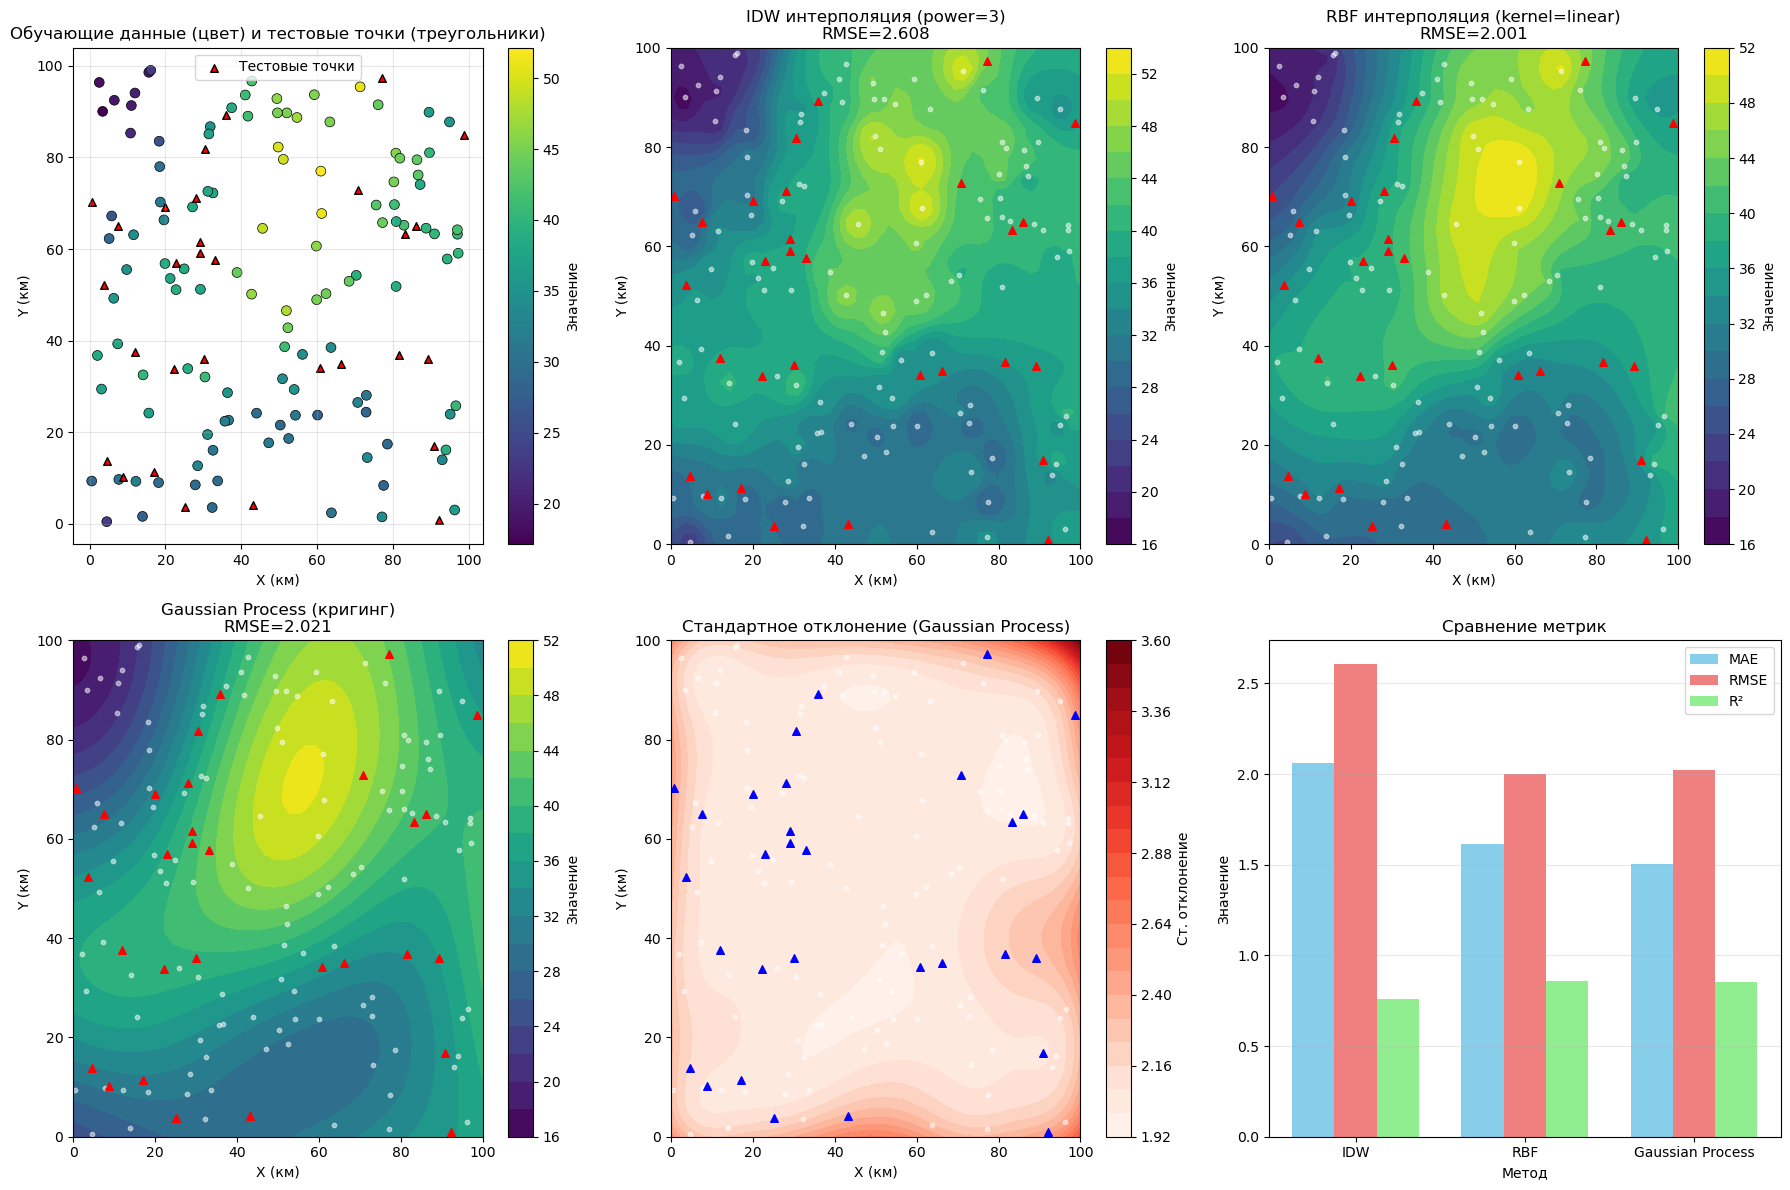

In [10]:
# 8. ВИЗУАЛИЗАЦИЯ

print("\n" + "="*80)
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Исходные данные
ax = axes[0, 0]
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, 
                     cmap='viridis', s=50, edgecolor='black', linewidth=0.5,
                     vmin=y.min(), vmax=y.max())
ax.scatter(X_test[:, 0], X_test[:, 1], c='red', s=30, marker='^', 
           label='Тестовые точки', edgecolor='black')
ax.set_xlabel('X (км)')
ax.set_ylabel('Y (км)')
ax.set_title('Обучающие данные (цвет) и тестовые точки (треугольники)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Значение')

# 2. IDW поверхность
ax = axes[0, 1]
contour = ax.contourf(grid_x, grid_y, grid_z_idw, levels=20, cmap='viridis')
ax.scatter(X_train[:, 0], X_train[:, 1], c='white', s=10, alpha=0.5)
ax.scatter(X_test[:, 0], X_test[:, 1], c='red', s=30, marker='^')
ax.set_xlabel('X (км)')
ax.set_ylabel('Y (км)')
ax.set_title(f'IDW интерполяция (power={best_power})\nRMSE={rmse_idw:.3f}')
plt.colorbar(contour, ax=ax, label='Значение')

# 3. RBF поверхность
ax = axes[0, 2]
contour = ax.contourf(grid_x, grid_y, grid_z_rbf, levels=20, cmap='viridis')
ax.scatter(X_train[:, 0], X_train[:, 1], c='white', s=10, alpha=0.5)
ax.scatter(X_test[:, 0], X_test[:, 1], c='red', s=30, marker='^')
ax.set_xlabel('X (км)')
ax.set_ylabel('Y (км)')
ax.set_title(f'RBF интерполяция (kernel={best_kernel})\nRMSE={rmse_rbf:.3f}')
plt.colorbar(contour, ax=ax, label='Значение')

# 4. Gaussian Process поверхность
ax = axes[1, 0]
contour = ax.contourf(grid_x, grid_y, grid_z_gpr, levels=20, cmap='viridis')
ax.scatter(X_train[:, 0], X_train[:, 1], c='white', s=10, alpha=0.5)
ax.scatter(X_test[:, 0], X_test[:, 1], c='red', s=30, marker='^')
ax.set_xlabel('X (км)')
ax.set_ylabel('Y (км)')
ax.set_title(f'Gaussian Process (кригинг)\nRMSE={rmse_gpr:.3f}')
plt.colorbar(contour, ax=ax, label='Значение')

# 5. Стандартное отклонение Gaussian Process
ax = axes[1, 1]
contour = ax.contourf(grid_x, grid_y, grid_z_std, levels=20, cmap='Reds')
ax.scatter(X_train[:, 0], X_train[:, 1], c='white', s=10, alpha=0.5)
ax.scatter(X_test[:, 0], X_test[:, 1], c='blue', s=30, marker='^')
ax.set_xlabel('X (км)')
ax.set_ylabel('Y (км)')
ax.set_title('Стандартное отклонение (Gaussian Process)')
plt.colorbar(contour, ax=ax, label='Ст. отклонение')

# 6. Сравнение методов (bar chart)
ax = axes[1, 2]
x_pos = np.arange(len(results))
width = 0.25

ax.bar(x_pos - width, results['MAE'], width, label='MAE', color='skyblue')
ax.bar(x_pos, results['RMSE'], width, label='RMSE', color='lightcoral')
ax.bar(x_pos + width, results['R²'], width, label='R²', color='lightgreen')

ax.set_xlabel('Метод')
ax.set_ylabel('Значение')
ax.set_title('Сравнение метрик')
ax.set_xticks(x_pos)
ax.set_xticklabels(results['Метод'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

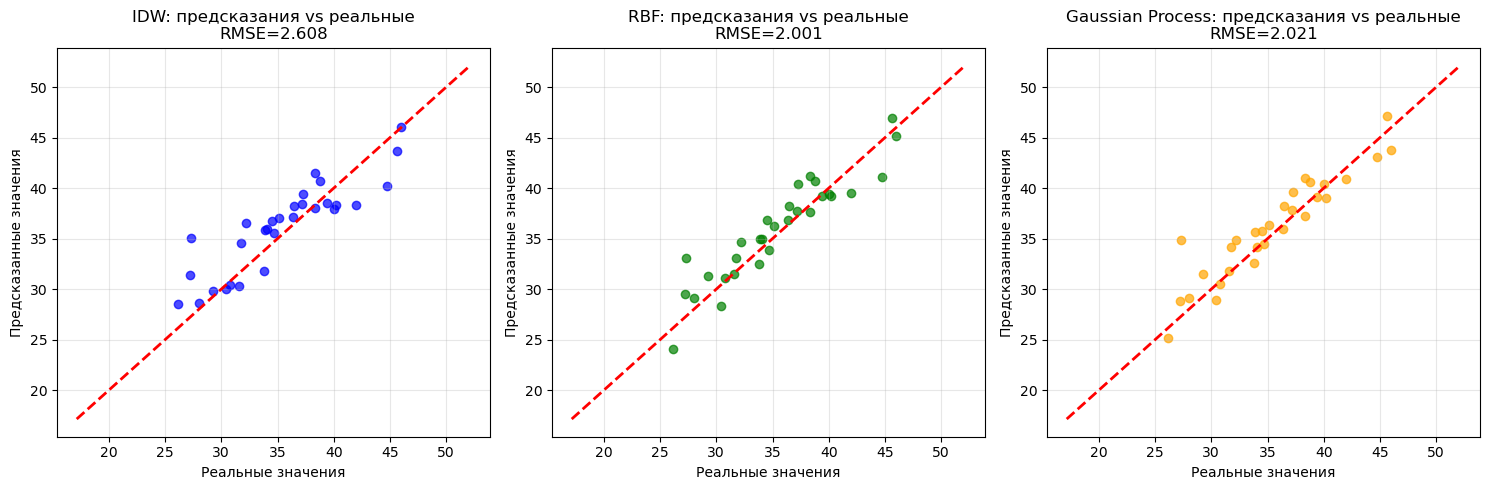

In [11]:
# 9. ДОПОЛНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ: ПРЕДСКАЗАНИЯ VS РЕАЛЬНЫЕ

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# IDW
ax = axes[0]
ax.scatter(y_test, y_pred_idw, alpha=0.7, color='blue')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
ax.set_xlabel('Реальные значения')
ax.set_ylabel('Предсказанные значения')
ax.set_title(f'IDW: предсказания vs реальные\nRMSE={rmse_idw:.3f}')
ax.grid(True, alpha=0.3)

# RBF
ax = axes[1]
ax.scatter(y_test, y_pred_rbf, alpha=0.7, color='green')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
ax.set_xlabel('Реальные значения')
ax.set_ylabel('Предсказанные значения')
ax.set_title(f'RBF: предсказания vs реальные\nRMSE={rmse_rbf:.3f}')
ax.grid(True, alpha=0.3)

# Gaussian Process
ax = axes[2]
ax.scatter(y_test, y_pred_gpr, alpha=0.7, color='orange')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
ax.set_xlabel('Реальные значения')
ax.set_ylabel('Предсказанные значения')
ax.set_title(f'Gaussian Process: предсказания vs реальные\nRMSE={rmse_gpr:.3f}')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()